In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install shap


import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import dask.array as da
import dask.dataframe as dd
#from dask_ml.model_selection import train_test_split
from dask.distributed import Client
from xgboost.callback import EarlyStopping
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 21.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
output_train_dir = '/content/drive/MyDrive/archive/preprocessed_training'
output_test_dir = '/content/drive/MyDrive/archive/preprocessed_testing'
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
def load_images(data_dir, labels, img_size=(128, 128)):
    images = []
    image_labels = []
    for label in labels:
        class_dir = os.path.join(data_dir, label)
        for img_path in os.listdir(class_dir):
            img = cv2.imread(os.path.join(class_dir, img_path))
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                image_labels.append(label)
    images = np.array(images)
    image_labels = np.array(image_labels)
    return images, image_labels

In [ ]:
# Loading preprocessed images
x_train_images, y_train_labels = load_images(output_train_dir, labels)
x_test_images, y_test_labels = load_images(output_test_dir, labels)

In [ ]:
# Flattening the images to 1D arrays
x_train = x_train_images.reshape((x_train_images.shape[0], -1))
x_test = x_test_images.reshape((x_test_images.shape[0], -1))

In [ ]:
# Encoding labels as integers
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(f'Training data shape: {x_train.shape}, {y_train.shape}')
print(f'Validation data shape: {x_val.shape}, {y_val.shape}')
print(f'Testing data shape: {x_test.shape}, {y_test.shape}')

Training data shape: (4569, 49152), (4569,)
Validation data shape: (1143, 49152), (1143,)
Testing data shape: (1311, 49152), (1311,)


In [ ]:
# Converting data to float32 to reduce memory usage
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

# Ensure y values are int32
y_train = y_train.astype('int32')
y_val = y_val.astype('int32')
y_test = y_test.astype('int32')

In [ ]:
batch_size = 16

dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_val, label=y_val)
dtest = xgb.DMatrix(x_test, label=y_test)


params = {
    'objective': 'multi:softprob',
    'num_class': len(labels),
    'eval_metric': 'mlogloss',
    'use_label_encoder': False,
    'seed': 42
}

# Setting up evaluation list
eval_list = [(dval, 'eval')]

evals_result = {}


# Training the model in batches
bst = None
for i in range(0, len(x_train), batch_size):
    dtrain_batch = xgb.DMatrix(x_train[i:i+batch_size], label=y_train[i:i+batch_size])
    bst = xgb.train(params, dtrain_batch, xgb_model=bst, num_boost_round=10, evals=eval_list, early_stopping_rounds=10, verbose_eval=False, evals_result=evals_result)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:21:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:22:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:22:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:22:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:22:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

In [ ]:
dtest = xgb.DMatrix(x_test, label=y_test)
y_pred = bst.predict(dtest)
y_pred_labels = np.argmax(y_pred, axis=1)

In [ ]:
y_train_pred = np.argmax(bst.predict(dtrain), axis=1)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy: {train_accuracy}')

accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Test Accuracy: {accuracy}')

class_report = classification_report(y_test, y_pred_labels, target_names=labels)
print('Classification Report:')
print(class_report)

Training Accuracy: 0.6266141387612169
Test Accuracy: 0.5705568268497331
Classification Report:
              precision    recall  f1-score   support

      glioma       0.56      0.60      0.58       300
  meningioma       0.37      0.29      0.33       306
     notumor       0.71      0.73      0.72       405
   pituitary       0.56      0.62      0.59       300

    accuracy                           0.57      1311
   macro avg       0.55      0.56      0.55      1311
weighted avg       0.56      0.57      0.56      1311



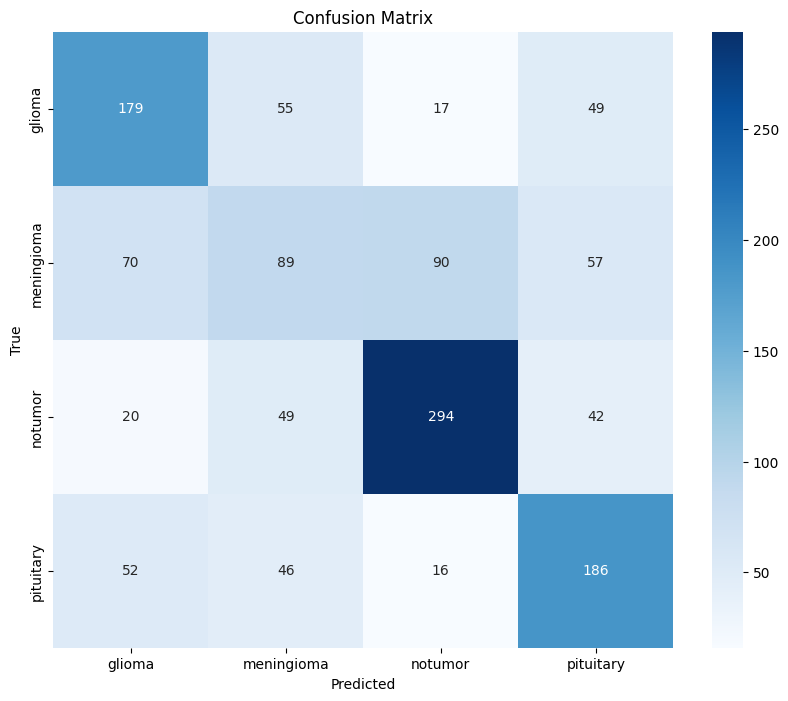

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

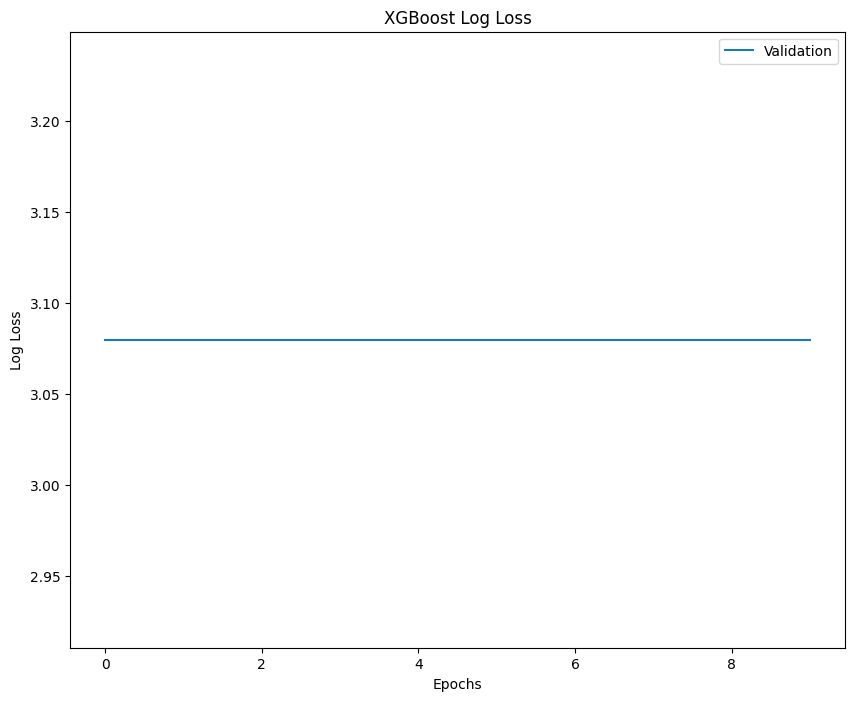

In [ ]:
#results = bst.evals_result()
epochs = len(evals_result['eval']['mlogloss'])
x_axis = range(0, epochs)
plt.figure(figsize=(10, 8))
plt.plot(x_axis, evals_result['eval']['mlogloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.legend()
plt.show()

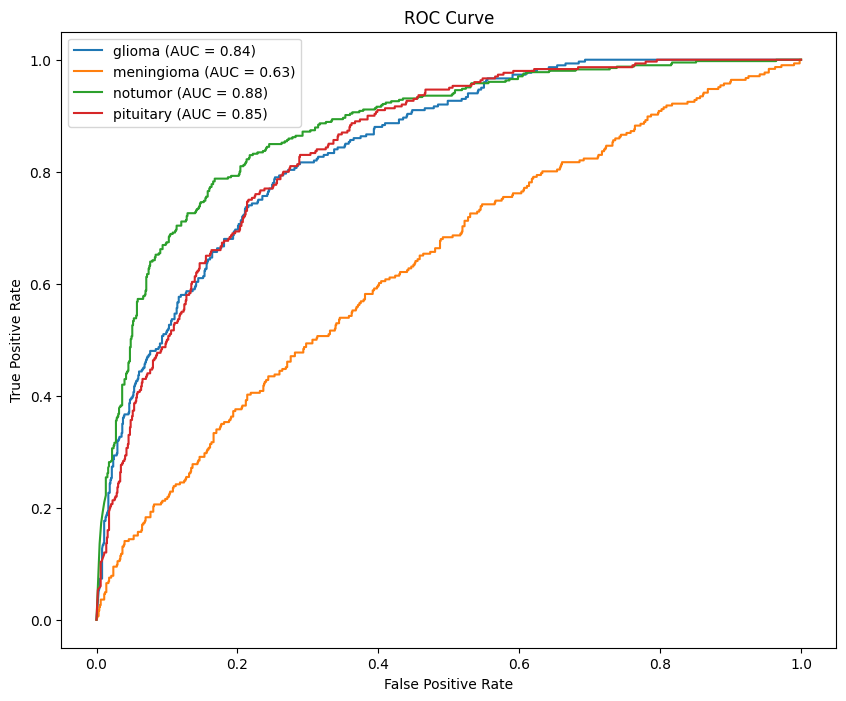

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred[:, i])
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_score(y_test == i, y_pred[:, i]):.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
def load_and_resize_images(image_dir, labels, target_size=(224, 224)):
    images = []
    labels_list = []
    for label in labels:
        path = os.path.join(image_dir, label)
        for file in os.listdir(path):
            img_path = os.path.join(path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                images.append(img)
                labels_list.append(labels.index(label))
    return np.array(images), np.array(labels_list)

In [ ]:
x_train_images, y_train_labels = load_and_resize_images(output_train_dir, labels)
x_test_images, y_test_labels = load_and_resize_images(output_test_dir, labels)

In [ ]:


x_train_images, x_val_images, y_train, y_val = train_test_split(x_train_images, y_train_labels, test_size=0.2, random_state=42)

In [ ]:
# Loading the EfficientNetB7 model, excluding the top layers
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [ ]:
# Extracting features
x_train_features = model.predict(x_train_images)
x_val_features = model.predict(x_val_images)
x_test_features = model.predict(x_test_images)

143/143 ━━━━━━━━━━━━━━━━━━━━ 2668s 19s/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 658s 18s/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 750s 18s/step


In [ ]:
y_train = y_train.astype('int32')
y_val = y_val.astype('int32')
y_test_labels = y_test_labels.astype('int32')

In [ ]:
dtrain = xgb.DMatrix(x_train_features, label=y_train)
dval = xgb.DMatrix(x_val_features, label=y_val)
dtest = xgb.DMatrix(x_test_features, label=y_test_labels)

In [ ]:
params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_train)),
    'eval_metric': 'mlogloss',
    'use_label_encoder': False,
    'seed': 42
}

evals_result = {}
eval_list = [(dtrain, 'train'), (dval, 'eval')]
bst = xgb.train(params, dtrain, num_boost_round=100, evals=eval_list, early_stopping_rounds=10, evals_result=evals_result)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:45:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:1.00664	eval-mlogloss:1.08572
[1]	train-mlogloss:0.77833	eval-mlogloss:0.90511
[2]	train-mlogloss:0.61940	eval-mlogloss:0.78021
[3]	train-mlogloss:0.49827	eval-mlogloss:0.68619
[4]	train-mlogloss:0.40598	eval-mlogloss:0.61509
[5]	train-mlogloss:0.33263	eval-mlogloss:0.55645
[6]	train-mlogloss:0.27535	eval-mlogloss:0.50838
[7]	train-mlogloss:0.22963	eval-mlogloss:0.47001
[8]	train-mlogloss:0.19317	eval-mlogloss:0.43935
[9]	train-mlogloss:0.16460	eval-mlogloss:0.41495
[10]	train-mlogloss:0.13957	eval-mlogloss:0.39360
[11]	train-mlogloss:0.12020	eval-mlogloss:0.37501
[12]	train-mlogloss:0.10248	eval-mlogloss:0.35812
[13]	train-mlogloss:0.08866	eval-mlogloss:0.34497
[14]	train-mlogloss:0.07708	eval-mlogloss:0.32990
[15]	train-mlogloss:0.06643	eval-mlogloss:0.31851
[16]	train-mlogloss:0.05804	eval-mlogloss:0.30898
[17]	train-mlogloss:0.05038	eval-mlogloss:0.30007
[18]	train-mlogloss:0.04470	eval-mlogloss:0.29238
[19]	train-mlogloss:0.03954	eval-mlogloss:0.28685
[20]	train

In [ ]:
# Predicting on the test set
y_pred = bst.predict(dtest)
y_pred_labels = np.argmax(y_pred, axis=1)

In [ ]:
# Evaluating the model
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.9366895499618612


In [ ]:
# Predicting on the training set
y_train_pred = bst.predict(dtrain)
y_train_pred_labels = np.argmax(y_train_pred, axis=1)

# Training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_labels)
print(f'Training Accuracy: {train_accuracy}')

Training Accuracy: 1.0


In [ ]:
class_report = classification_report(y_test_labels, y_pred_labels, target_names=labels)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.83      0.89       300
  meningioma       0.88      0.93      0.90       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.94      0.96      0.95       300

    accuracy                           0.94      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



Confusion Matrix:
[[250  34   6  10]
 [  8 285   3  10]
 [  0   1 404   0]
 [  6   5   0 289]]


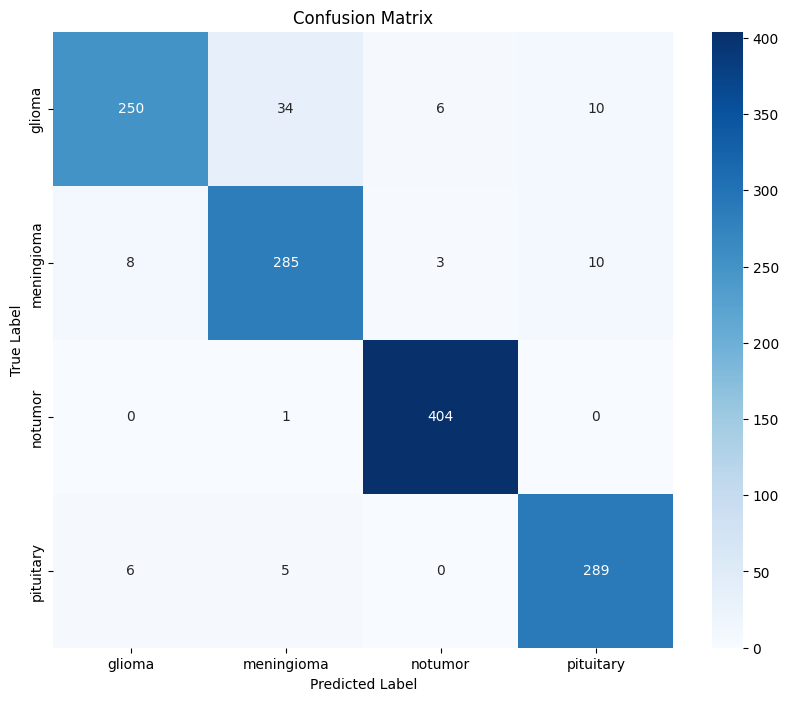

In [ ]:
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

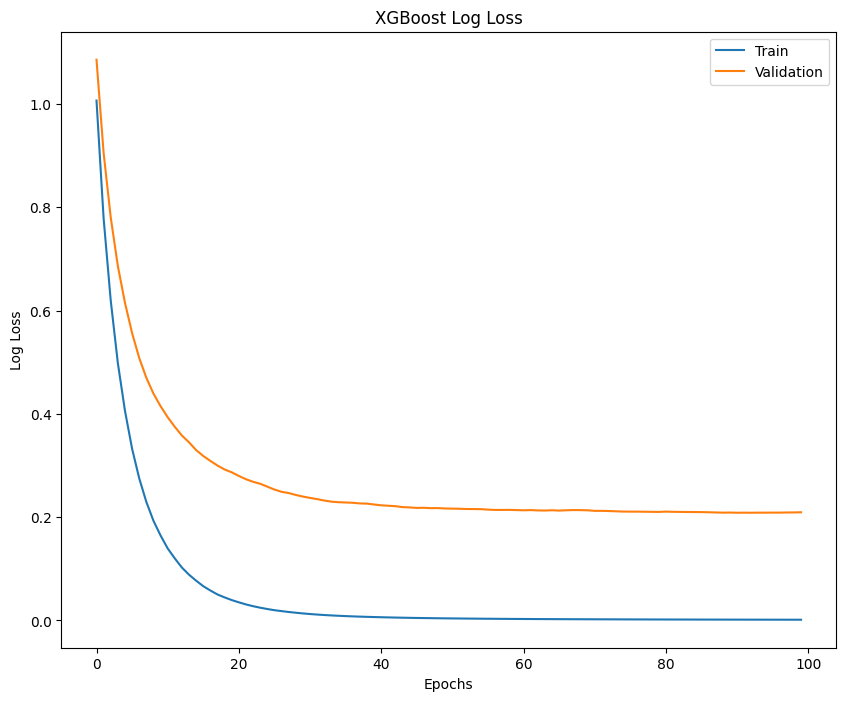

In [ ]:
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 8))
plt.plot(x_axis, evals_result['train']['mlogloss'], label='Train')
plt.plot(x_axis, evals_result['eval']['mlogloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.legend()
plt.show()